## Gerando dataset sintetico

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def gen_center(depth=100, points=1000, Ts=[10, 15, 30, 50], edges=(250, 100)):    
    x = np.linspace(0, depth, points)
    scale = min(Ts)
    labels = [edges[0]]
    y = np.zeros(x.shape)

    for T_i in Ts:
        T = np.random.uniform(0.7*T_i, 1.3*T_i)
        scale_sig = np.random.choice([-1,1])*scale
        y_i = np.concatenate((np.zeros(edges[0]), scale_sig*np.sin(x*2*np.pi/T)[edges[0]:-edges[1]]/T, np.zeros(edges[1])))
        y += y_i
    y += np.random.normal(0, 0.1, x.size)
    return labels, y, x

In [2]:
def gen_dataset(scale = 0.5, n_series = 30, max_roll_factor = 40, **kwargs):
    labels, y, x = gen_center(**kwargs)

    roll_factor = np.random.randint(-max_roll_factor, max_roll_factor+1)
    y2 = scale*(y + np.roll(y, roll_factor))
    labels.append(labels[0] + roll_factor)
    
    temp_series = [y, y2]
    for i in range(n_series):
        roll_factor = np.random.randint(-max_roll_factor, max_roll_factor+1)

        if i % 2 == 0:
            y_base = temp_series[0]
            label_new = labels[0] + roll_factor
            y_new = scale*(y_base + np.roll(y_base, roll_factor))
            temp_series = [y_new] + temp_series
            labels = [label_new] + labels
        else:
            y_base = temp_series[-1]
            label_new = labels[-1] + roll_factor
            y_new = scale*(y_base + np.roll(y_base, roll_factor))
            temp_series = temp_series + [y_new]
            labels = labels + [label_new] 
    temp_series = np.asarray(temp_series)
    labels = np.asarray(labels)

    return x, temp_series, labels

In [3]:
def gen_database(n_cases=100, **kwargs):
    # db = [{'series': ..., 'labels': ...} for _ in range(n_cases)]
    data = []
    labels = []
    for i in range(n_cases):
        x, temp_series, label = gen_dataset()
        data.append(temp_series)
        labels.append(label)
    return np.asarray(x), np.asarray(data), np.asarray(labels)

x, data, labels = gen_database()

## Visualização

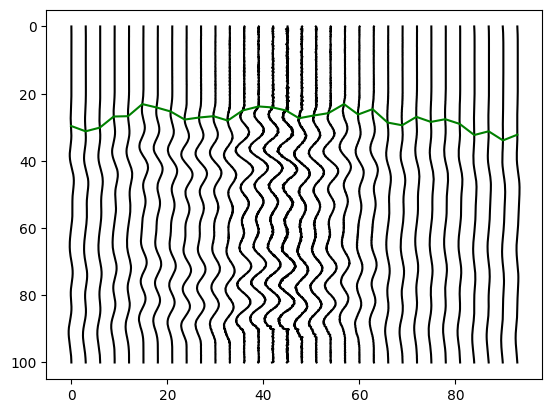

In [4]:
def view_data(x, data, idx=None, labels=None, offset_view=3, synthetic=True, **kwargs):
    if idx != None:
        temp_series = data[idx]
    else:
        temp_series = data

    if labels is not None:
        label = labels[idx]

    _, ax = plt.subplots()
    if synthetic:
        x_label = []
        for i in range(temp_series.shape[0]):
            ax.plot(temp_series[i] + offset_view*i, x, c='black')
            if labels is not None:
                x_label.append(temp_series[i][label[i]] + offset_view*i)
        if labels is not None:
            ax.plot(x_label, label/(len(x)/max(x)), c='green')
        ax.invert_yaxis()
    else:
        _ = ax.imshow(temp_series.T, cmap='gray',vmin=-500, vmax=500, interpolation='nearest', aspect='auto')
        if labels is not None:
            _ = ax.plot(labels, '-', color='green')
    return ax

ax = view_data(x, data, 22, labels)

In [5]:
def moving_average(data, window_size=3):
    weights = np.repeat(1.0, window_size) / window_size
    return np.convolve(data, weights, 'valid')

def find_first_peak(time_series, threshold=1):
    smoothed_series = moving_average(time_series)
    
    z_scores = (smoothed_series - np.mean(smoothed_series)) / np.std(smoothed_series)

    # threshold = 1  # Adjust as needed based on the characteristics of your data
    significant_peaks = [(i, score) for i, score in enumerate(z_scores) if abs(score) > threshold]

    if significant_peaks:
        first_peak_index, _ = significant_peaks[0]
        return first_peak_index
    else:
        return None


In [6]:
def find_breaks(data, idx=0, threshold=1):    
    temp_series = data[idx]
    peaks = []
    for serie in temp_series:
        peaks.append(find_first_peak(serie, threshold=threshold))
    return np.asarray(peaks)

# ii = 14
# pk = find_breaks(data, ii)
# labels[ii] - pk

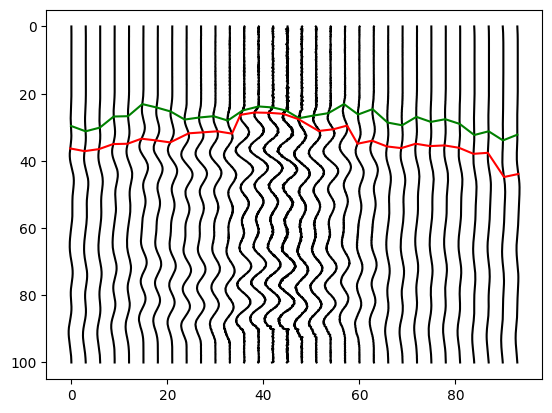

In [7]:
def plot_simple_breaks(x, data, ax, idx=0, offset_view=3, method=find_breaks, threshold=1, synthetic=True):
    if synthetic:
        peaks = method(data, idx, threshold)
        temp_series = data[idx]
        x_label = []
        for i, serie in enumerate(temp_series):
            x_label.append(serie[peaks[i]] + offset_view*i)
        ax.plot(x_label, peaks/(len(x)/max(x)), c='red')
    else:
        peaks = method(data[np.newaxis, ...], 0, threshold)
        # temp_series = data
        ax.plot(peaks, '-', color='red')
    return peaks

ii = 22
ax = view_data(x, data, ii, labels)
_ = plot_simple_breaks(x, data, ax, ii)

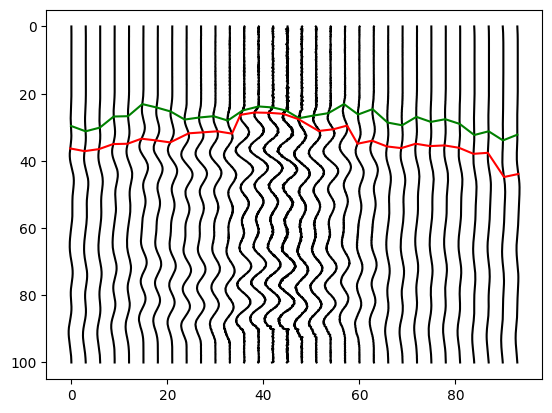

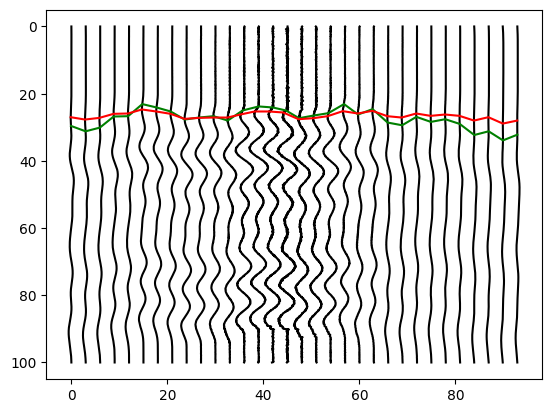

In [8]:
from fastdtw import fastdtw

def find_first_and_last(tuples_list, idx):
    first_occurrence = None
    last_occurrence = None
    
    for i, tpl in enumerate(tuples_list):
        if tpl[0] == idx:
            if first_occurrence is None:
                first_occurrence = tpl[1]
            last_occurrence = tpl[1]
    
    return first_occurrence, last_occurrence

def find_breaks_dtw(data, idx=0, threshold=1):    
    temp_series = data[idx]
    middle_idx = temp_series.shape[0] // 2
    peaks = [find_first_peak(temp_series[middle_idx], threshold=threshold)]

    for i in range(middle_idx, 0, -1):
        _, path = fastdtw(temp_series[i], temp_series[i-1])
        first, last = find_first_and_last(path, peaks[-1])
        peaks.append(first)
        # peaks.append(last)
        # peaks.append((first+last) // 2)
    peaks.reverse()
    for i in range(middle_idx, temp_series.shape[0]-1):
        _, path = fastdtw(temp_series[i], temp_series[i+1])
        first, last = find_first_and_last(path, peaks[-1])
        peaks.append(first)
    return np.asarray(peaks)

ii = 22
ax = view_data(x, data, ii, labels)
_ = plot_simple_breaks(x, data, ax, ii)

ax = view_data(x, data, ii, labels)
_ = plot_simple_breaks(x, data, ax, ii, method=find_breaks_dtw)

## Segy

In [9]:
import zstandard as zstd
import segyio

def decompress_zstd(input_file, output_file):
    with open(input_file, 'rb') as compressed_file:
        dctx = zstd.ZstdDecompressor()
        with dctx.stream_reader(compressed_file) as reader:
            with open(output_file, 'wb') as output:
                while True:
                    chunk = reader.read(4096)
                    if not chunk:
                        break
                    output.write(chunk)

# Example usage
input_file = 'full.sgy.zstd'
output_file = 'full.sgy'
decompress_zstd(input_file, output_file)

In [10]:
def get_traces(file_path, sample_field=1):
    cube = []
    with segyio.open(file_path, "r", 9, 17) as segyfile:
        # Iterate over traces and filter by inline number
        last_field = segyfile.header[-1][segyio.TraceField.FieldRecord]
        first_field = segyfile.header[0][segyio.TraceField.FieldRecord]
        
        for i in range(segyfile.tracecount):
            if segyfile.header[i][segyio.TraceField.FieldRecord] != first_field:
                size_field = i
                break

        for i in range(0, last_field, sample_field):
            traces = []
            for j in range(size_field):
                k = i*size_field + j
                traces.append(segyfile.trace[k])
            cube.append(traces)

    return np.asarray(cube)

def get_traces_simple(file_path):
    traces = []
    with segyio.open(file_path, "r", 1, 5) as segyfile:
        for i in range(segyfile.tracecount):
            traces.append(segyfile.trace[i])
    return np.asarray(traces)

def verify_valid_segy(file_path):
    for i in range(1000):
        for j in range(1000):
            try:
                with segyio.open(file_path, "r", i, j) as _:
                    print(f"success: {i} - {j}")
            except:
                pass

# file_path = 'real_gather.sgy'
# data_segy = get_traces_simple(file_path)

file_path = 'full.sgy'
data_segy = get_traces(file_path, sample_field=3)
# verify_valid_segy(file_path)

## GIFs

In [11]:
import imageio
from skimage.transform import resize

min_value = np.min(data_segy)
max_value = np.max(data_segy)
rescaled_cube = ((data_segy - min_value) / (max_value - min_value)) * 255
rescaled_cube = rescaled_cube.astype(np.uint8)

output_gif_path = 'output.gif'
# Duration (in seconds) for each frame of the GIF
frame_duration = 0.3  # Adjust as needed

# Create GIF
with imageio.get_writer(output_gif_path, mode='I', duration=frame_duration) as writer:
    w, h = 800, 400
    for frame in rescaled_cube:
        resized_frame = resize(frame.T, (h, w), anti_aliasing=True)
        resized_frame = (resized_frame * 255).astype(np.uint8)
        writer.append_data(resized_frame)

In [12]:
output_gif_path = 'output_2.gif'

transposed_cube = np.swapaxes(rescaled_cube, 0, 1)

with imageio.get_writer(output_gif_path, mode='I', duration=frame_duration) as writer:
    w, h = 800, 400
    for frame in transposed_cube:
        resized_frame = resize(frame.T, (h, w), anti_aliasing=True)
        resized_frame = (resized_frame * 255).astype(np.uint8)
        writer.append_data(resized_frame)

## First Breaks

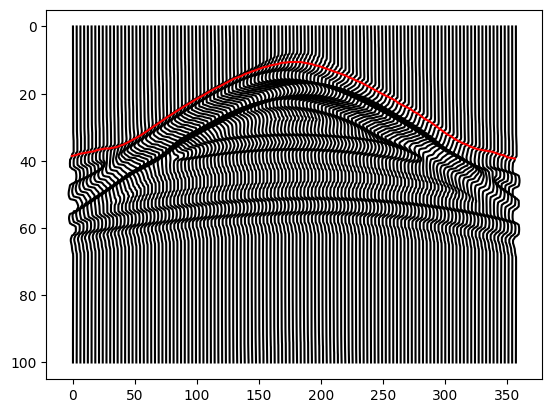

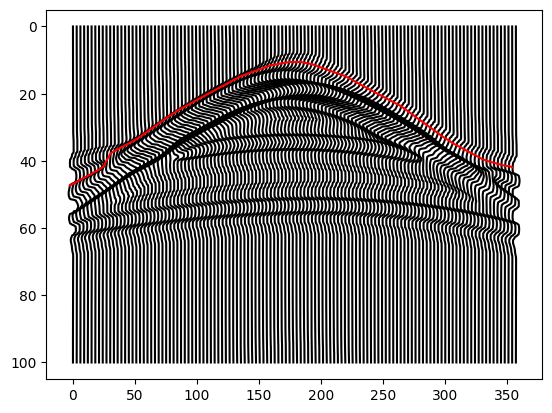

In [13]:
x_segy = np.linspace(0, 100, data_segy.shape[-1])
ii = 10
t_hold = 0.7
ax = view_data(x_segy, data_segy, ii)
_ = plot_simple_breaks(x_segy, data_segy, ax, ii, threshold=t_hold)

ax = view_data(x_segy, data_segy, ii)
_ = plot_simple_breaks(x_segy, data_segy, ax, ii, method=find_breaks_dtw, threshold=t_hold)

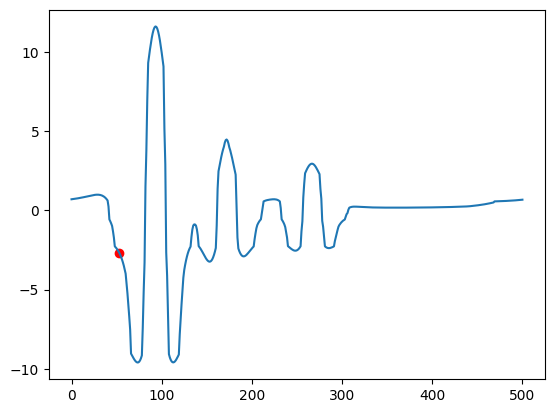

In [14]:
idx = 10
serie = data_segy[idx, data_segy.shape[1]//2]
peak = find_first_peak(serie, threshold=t_hold)

_ = plt.plot(serie)
_ = plt.scatter(peak, serie[peak], c='red')

## Test data

In [15]:
import gzip

def unzip_gz_file(gz_file_path, output_path):
    with gzip.open(gz_file_path, 'rb') as gz_file:
        with open(output_path, 'wb') as output_file:
            output_file.write(gz_file.read())

# Example usage:
# gz_file_path = 'sismica1.npy.gz'
# output_path = 'sismica1.npy'

# unzip_gz_file(gz_file_path, output_path)

In [16]:
pick, sism = np.loadtxt('picking1.npy'), np.loadtxt('sismica1.npy')
sism = np.swapaxes(sism, 0, 1)
# sism = sism[np.newaxis, ...]

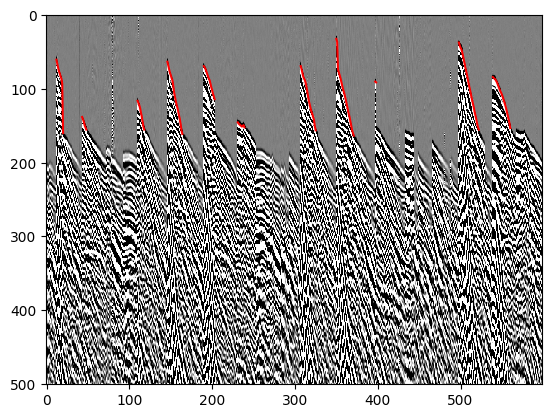

In [17]:
fig, ax = plt.subplots()
_ = ax.imshow(sism.T, cmap='gray',vmin=-500, vmax=500, interpolation='nearest', aspect='auto')
_ = ax.plot(pick, '-', color='red')


In [18]:
import copy

minimum, maximum = -500, 500
# scaled_sism = (sism - minimum) / (maximum - minimum)
scaled_sism = copy.deepcopy(sism)
scaled_sism[scaled_sism > maximum] = maximum
scaled_sism[scaled_sism < minimum] = minimum

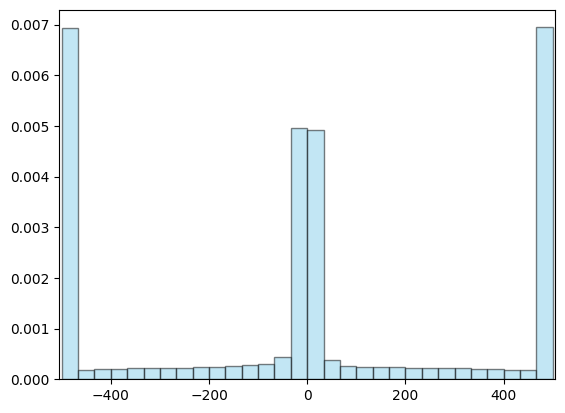

In [19]:
# sism.max()
_ = plt.hist(scaled_sism.flatten(), bins=30, density=True, alpha=0.5, color='skyblue', edgecolor='black') # Histogram
_ = plt.xlim(-505,505)

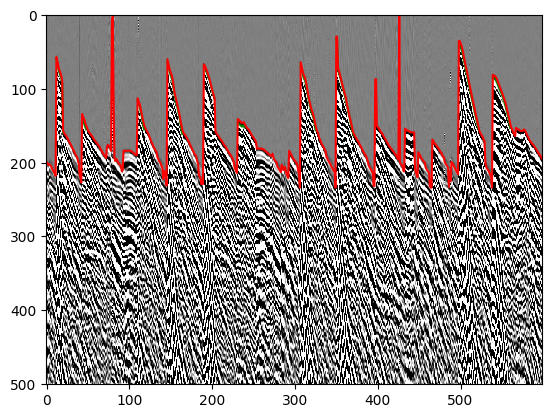

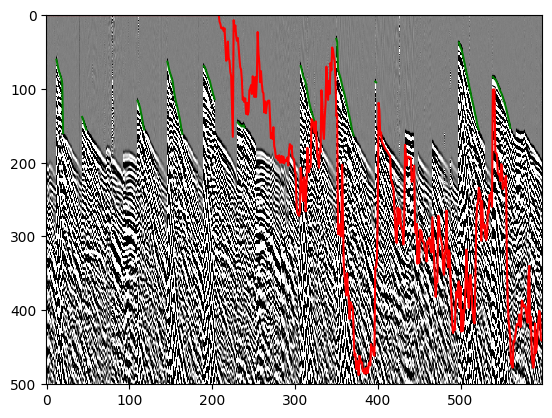

In [20]:
x_segy = np.arange(scaled_sism.shape[-1])
# ii = 0
t_hold = 0.7
ax = view_data(x_segy, sism, labels=pick, synthetic=False)
peaks = plot_simple_breaks(x_segy, scaled_sism, ax, ii, threshold=t_hold, synthetic=False)

ax = view_data(x_segy, sism, labels=pick, synthetic=False)
_ = plot_simple_breaks(x_segy, scaled_sism, ax, ii, method=find_breaks_dtw, threshold=t_hold, synthetic=False)

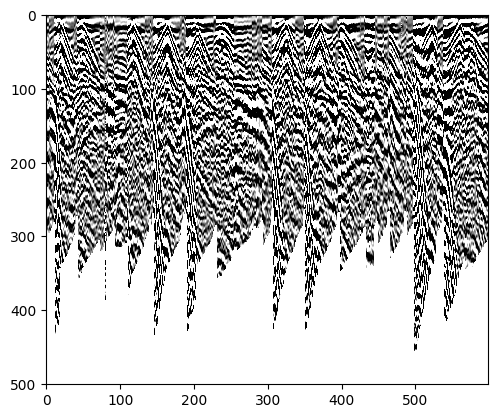

In [27]:
for pk, trace in zip(peaks, sism):
    trace[:pk] = np.nan
    trace[:] = np.roll(trace, -pk)
plt.imshow(sism.T, vmin=-500, vmax=500, cmap='gray')

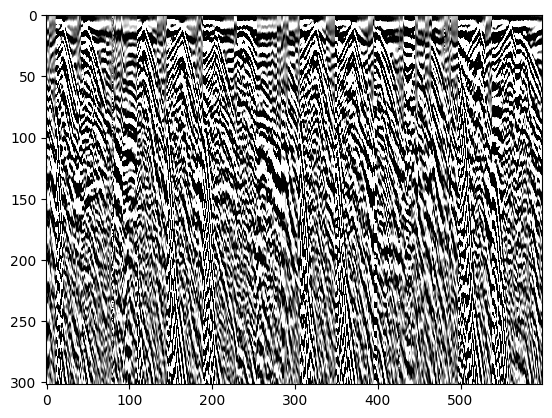

In [28]:
end_depth = sism.shape[1] - peaks
end_point_factor = 0.85
new_depth = int(sism.shape[1] - end_point_factor * (end_depth.max() - end_depth.min()))
new_sism = []

for end, trace in zip(end_depth, sism):
    x = np.linspace(0,100, end)
    new_x = np.linspace(0,100, new_depth)
    clean_trace = trace[~np.isnan(trace)]
    new_sism.append(np.interp(new_x, x, clean_trace))
new_sism = np.asarray(new_sism)
_ = plt.imshow(new_sism.T, vmin=-500, vmax=500, cmap='gray', aspect='auto')

In [29]:
points = 20
data = new_sism
centers = np.linspace(1, data.shape[1]-1, points, dtype=int)[..., np.newaxis]
middle_idx = data.shape[0] // 2
# middle_idx = 400

def find_ocurrences(tuples_list, idx):
    first_occurrence = [None for _ in idx]
    last_occurrence = [0 for _ in idx]
    
    for tpl in tuples_list:
        for j, ii in enumerate(idx):
            if tpl[0] == ii:
                if first_occurrence[j] is None:
                    first_occurrence[j] = tpl[1]
                last_occurrence[j] = tpl[1]
    
    return np.asarray(first_occurrence), np.asarray(last_occurrence)

for i in range(middle_idx, 0, -1):
    _, path = fastdtw(data[i], data[i-1])
    first, last = find_ocurrences(path, centers[:, -1])
    # peaks.append(first)
    centers = np.concatenate((centers, first[..., np.newaxis]), axis=1)
    # peaks.append(last)
    # peaks.append((first+last) // 2)
centers = centers[:, ::-1]

for i in range(middle_idx, data.shape[0]-1):
    _, path = fastdtw(data[i], data[i+1])
    first, last = find_ocurrences(path, centers[:, -1])
    centers = np.concatenate((centers, first[..., np.newaxis]), axis=1)


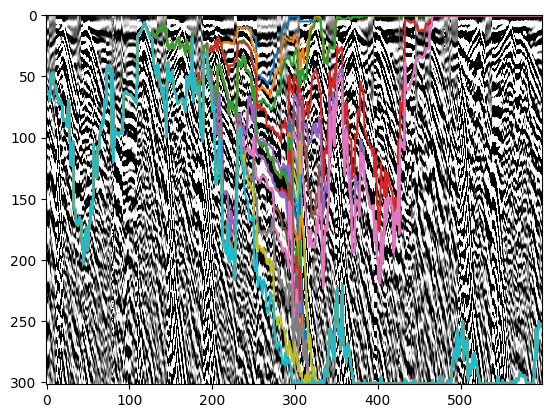

In [32]:
fig, ax = plt.subplots()
_ = ax.imshow(data.T, vmin=-500, vmax=500, cmap='gray', aspect='auto')
for line in centers:
    ax.plot(line)

## Gerador de dados do Russo

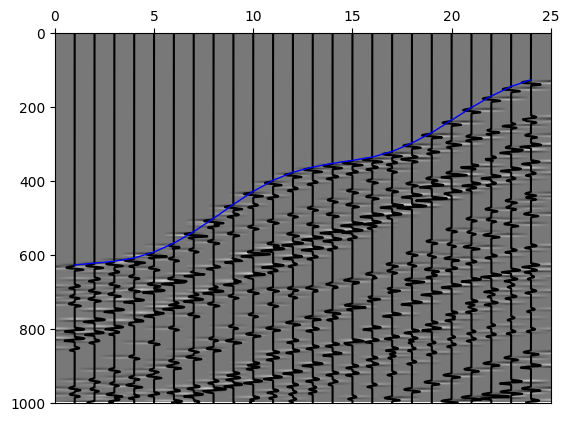

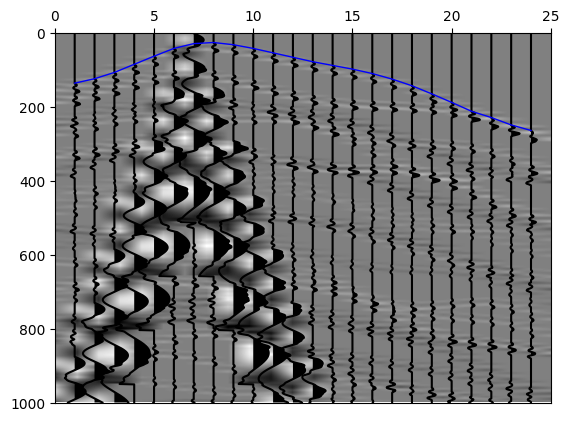

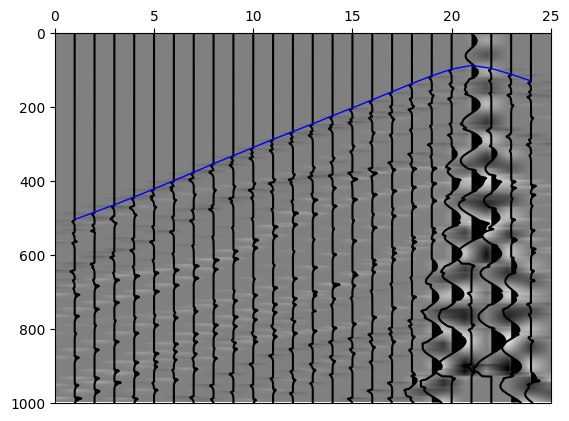

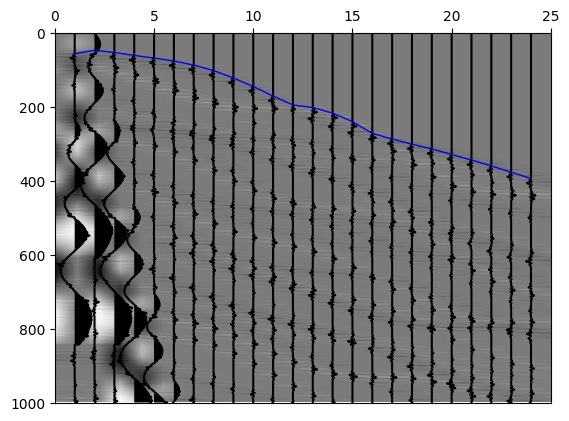

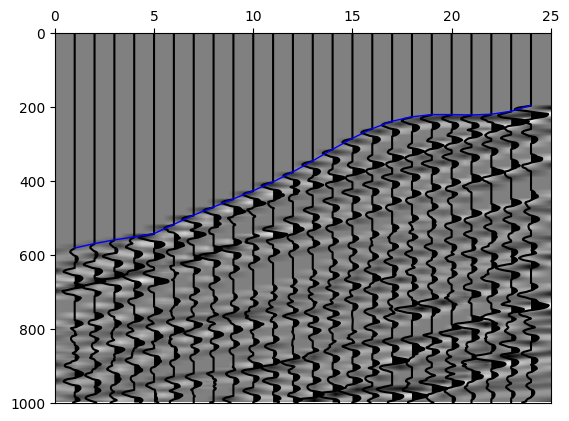

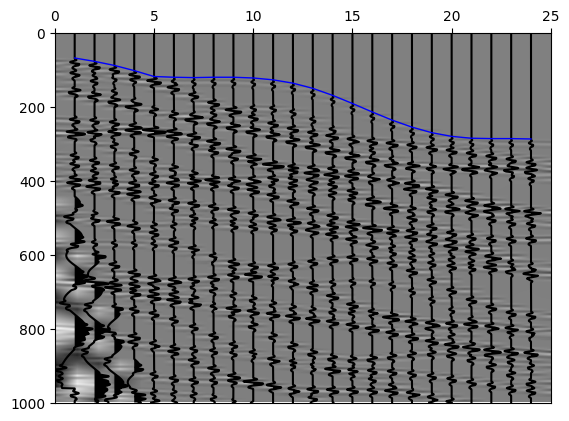

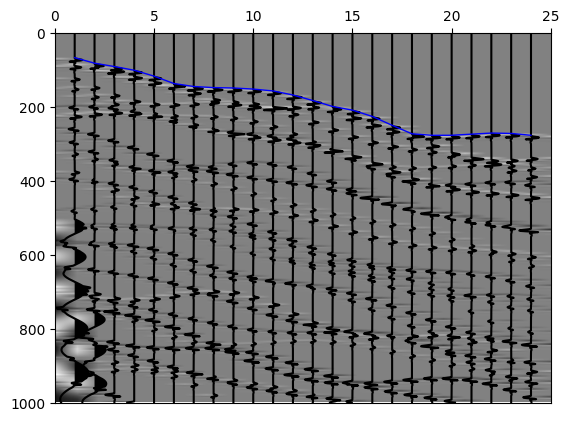

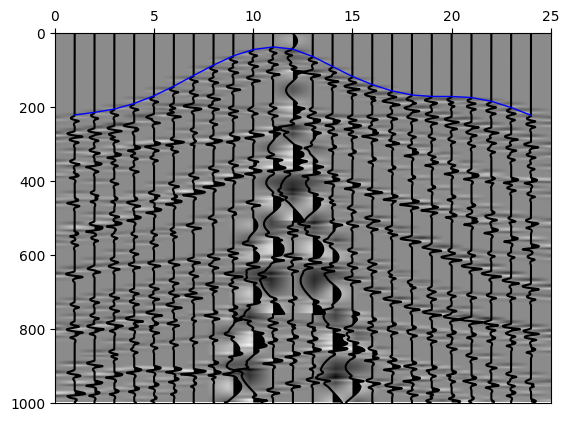

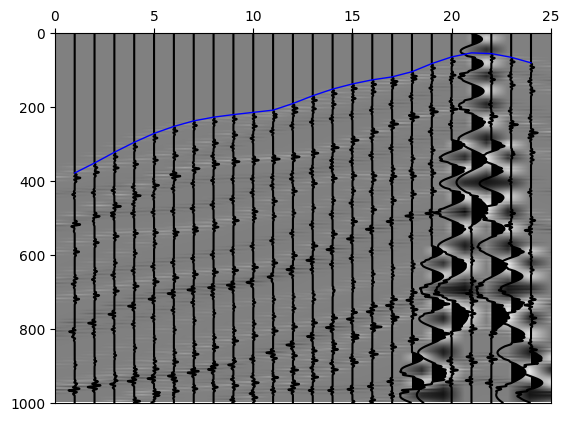

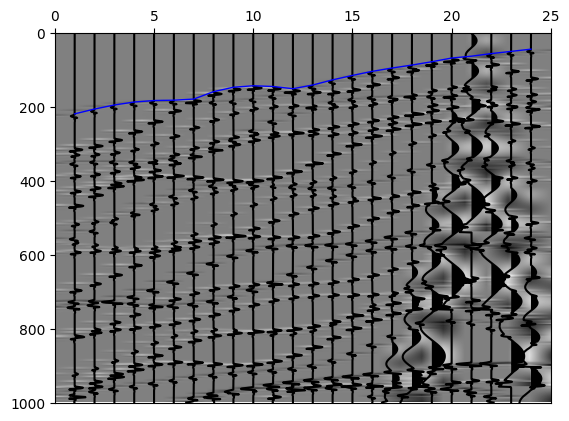

In [1]:
from UNet.code import utils, seis_model
from UNet.code.seis_model import SeisModel
import numpy as np
from UNet.code.utils import plotseis
import importlib
importlib.reload(utils)
importlib.reload(seis_model)

n_dataset = 10
base_path = "UNet/dataset/"
for i in range(n_dataset):
    seis_model = SeisModel()
    seismic_gather, picking_gather = seis_model.get_random_model()

    fig = plotseis(seismic_gather, picking_gather, colorseis=True)
    fig.savefig(f'{base_path}images/gather_{i}')
    np.save(f'{base_path}gather/gather_{i}.npy', seismic_gather)
    np.save(f'{base_path}labels/gather_{i}.npy', picking_gather)



In [46]:
# type(seismic_gather)
type(picking_gather)

numpy.ndarray